# STAT 4830 - Human vs Slop Essay Verifier
Train a **PyTorch verifier** to classify **human essays** vs **slop essays**.

This version utilizes this Kaggle dataset: https://www.kaggle.com/datasets/mannacharya/aeon-essays-dataset.


### How to use this notebook (recommended)
1) Run Setup + Data loading.
2) Start with **LLM slop generation** (title-based prompts) or quick corruption to sanity-check.
3) **Length-match** human and slop (critical) to avoid trivial solutions.
4) Train verifier, then inspect score distributions + hardest examples.
5) Save checkpoint and reuse `score_humanlikeness` later as a reward model.


## 0) Setup

In [ ]:
# === CELL SUMMARY ===
# Install required libraries for NLP + training.
# - transformers: pretrained models + tokenizers
# - datasets/evaluate: optional utilities
# - scikit-learn: metrics + splits
# Then set random seeds and choose device (GPU if available).
# ====================

!pip -q install transformers datasets accelerate evaluate scikit-learn tqdm

import os, random, numpy as np, pandas as pd, torch
from tqdm.auto import tqdm

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device, "| torch:", torch.__version__)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.7 MB/s eta 0:00:00
device: cuda | torch: 2.9.0+cu128


## 1) Load human essays (Kaggle `essays.csv`)
Upload `essays.csv` to Colab (or mount Drive) and set `HUMAN_CSV_PATH`.
We use the `essay` column as human text.


In [ ]:
# === CELL SUMMARY ===
# Load Kaggle human-essay dataset from CSV.
# We rename the `essay` column -> `text` and filter by character length.
# Goal: create the positive (human) class for the verifier.
# ====================

HUMAN_CSV_PATH = "essays.csv"  # <-- change if needed

df_human_raw = pd.read_csv(HUMAN_CSV_PATH)
print("raw shape:", df_human_raw.shape)
print("columns:", list(df_human_raw.columns))

# Use the 'essay' column as the human text
assert "essay" in df_human_raw.columns, "Expected a column named 'essay'"

df_human = df_human_raw.rename(columns={"essay": "text"})[["text"]].dropna()
df_human["text"] = df_human["text"].astype(str)

# Optional: filter extreme lengths (helps model stability & GPU memory)
min_chars, max_chars = 400, 20000
df_human = df_human[df_human["text"].str.len().between(min_chars, max_chars)].reset_index(drop=True)

print("filtered human essays:", len(df_human))
df_human.head()


raw shape: (2235, 6)
columns: ['title', 'description', 'essay', 'authors', 'source_url', 'thumbnail_url']
filtered human essays: 1029


,text
0,Shortly after Rachel Bespaloff’s suicide in 19...
1,"Years ago, my professor would make his archite..."
2,In the surreal aftermath of my suicide attempt...
3,I wore leggings that Tuesday. I never wore leg...
4,"In Washington state in 2002, Lydia Fairchild n..."


## 2) Slop generation

Started with synthetic slop to validate the notebook, then swapped in the Frozen-LLM generation in next cell.


In [ ]:
# === CELL SUMMARY ===
# Create quick synthetic 'slop' negatives by corrupting human text.
# This is a pipeline sanity-check (easy negatives). For realistic results, use the LLM generation cell.
# ====================

import re

def simple_sentence_split(text: str):
    sents = re.split(r'(?<=[.!?])\s+', text.strip())
    return [s for s in sents if s]

def make_corrupted_slop(text: str, rng: random.Random) -> str:
    sents = simple_sentence_split(text)
    if len(sents) >= 3:
        rng.shuffle(sents)
    out = " ".join(sents)

    # Inject repetition
    tokens = out.split()
    if len(tokens) > 40:
        phrase = " ".join(tokens[:10])
        out = out + " " + ((" " + phrase) * 3)

    # Add filler / generic phrasing
    fillers = [
        "In conclusion", "Basically", "Overall", "It is important to note that",
        "To be honest", "In today's world", "At the end of the day"
    ]
    out = fillers[rng.randrange(len(fillers))] + ", " + out
    return out

def build_slop_corpus_quick(df_human: pd.DataFrame, seed: int = 123) -> pd.DataFrame:
    rng = random.Random(seed)
    slop_texts = [make_corrupted_slop(t, rng) for t in df_human["text"].tolist()]
    return pd.DataFrame({"text": slop_texts})

df_slop = build_slop_corpus_quick(df_human)
print("slop essays (quick):", len(df_slop))
df_slop.head()


slop essays (quick): 1029


,text
0,"It is important to note that, She soon became ..."
1,"Overall, The three bird’s eye plans show its g..."
2,"Overall, Their terror of falling from a great ..."
3,"It is important to note that, I whispered: ‘Be..."
4,"At the end of the day, For instance, if your u..."


### Full-loop slop via frozen generator LLM
Generates longer slop essays utilizing title based prompts with titles from the Kaggle essay database.


In [ ]:
# === CELL SUMMARY ===
# Generate "slop" (negative) essays with a frozen generator LLM (distilgpt2).
# We build prompts from the dataset TITLE (to avoid leaking the human essay text),
# generate long continuations, strip any echoed prompt from the decoded output,
# and keep only generations within a target character-length window.
#
# NOTE: To fully avoid length-based shortcuts, apply the SAME length window to the
# human essays in the data-loading/filtering cell (or truncate both classes).
# ====================

from transformers import AutoTokenizer, AutoModelForCausalLM
import torch, pandas as pd, numpy as np, random, re
from tqdm.auto import tqdm

generator_name = "distilgpt2"  # fast baseline; you can swap later
tok_g = AutoTokenizer.from_pretrained(generator_name)
mod_g = AutoModelForCausalLM.from_pretrained(generator_name).to(device)

# GPT2-family doesn't always have a pad token; set it to eos for batching/generation
if tok_g.pad_token is None:
    tok_g.pad_token = tok_g.eos_token

def build_prompt_from_title(title: str) -> str:
    title = str(title).strip()
    if not title:
        title = "a meaningful topic"
    # The "Essay:" marker helps us strip cleanly later.
    return (
        f"Write a 700-1200 word essay titled: {title}. "
        f"Use a generic high-school essay style with an introduction, 2-3 body paragraphs, and a conclusion.\n"
        f"Essay:"
    )

def strip_prompt(full_text: str, prompt: str) -> str:
    # If the model echoed the prompt, remove it.
    if full_text.startswith(prompt):
        full_text = full_text[len(prompt):]
    # Also strip any leftover "Essay:" occurrences at the start
    full_text = re.sub(r"^\s*Essay:\s*", "", full_text).strip()
    return full_text

@torch.inference_mode()
def generate_one(prompt: str,
                 max_new_tokens: int = 900,
                 temperature: float = 0.9,
                 top_p: float = 0.95) -> str:
    inputs = tok_g(prompt, return_tensors="pt", truncation=True, max_length=256).to(device)
    out = mod_g.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        temperature=temperature,
        top_p=top_p,
        pad_token_id=tok_g.eos_token_id,
    )
    decoded = tok_g.decode(out[0], skip_special_tokens=True)
    return strip_prompt(decoded, prompt)

def build_slop_corpus_llm_from_titles(df_human_raw: pd.DataFrame,
                                      n: int = 500,
                                      min_chars: int = 1500,
                                      max_chars: int = 6000,
                                      seed: int = 42) -> pd.DataFrame:
    """
    Builds slop essays from TITLE prompts and filters to a length window so negatives aren't trivially short.
    """
    rng = random.Random(seed)

    # Sample rows with non-empty titles
    df = df_human_raw.copy()
    if "title" not in df.columns:
        raise ValueError("Expected df_human_raw to have a 'title' column for prompt building.")
    df["title"] = df["title"].astype(str)
    df = df[df["title"].str.strip().str.len() > 0].reset_index(drop=True)

    if len(df) == 0:
        raise ValueError("No usable titles found.")

    # We'll oversample because some generations will be too short/too long and get filtered out.
    oversample = int(n * 1.6)
    idxs = [rng.randrange(len(df)) for _ in range(oversample)]
    titles = [df.loc[i, "title"] for i in idxs]

    slop_texts = []
    for title in tqdm(titles, desc="Generating slop essays (LLM)"):
        prompt = build_prompt_from_title(title)
        essay = generate_one(prompt, max_new_tokens=900, temperature=0.9, top_p=0.95)

        # Length filter to avoid trivial short generations
        L = len(essay)
        if min_chars <= L <= max_chars:
            slop_texts.append(essay)

        if len(slop_texts) >= n:
            break

    df_slop = pd.DataFrame({"text": slop_texts})
    print("slop essays kept:", len(df_slop))
    if len(df_slop) > 0:
        print("mean chars slop:", df_slop["text"].str.len().mean())
    return df_slop

# ---- Run generation ----
# df_human_raw is your original dataframe with columns including: 'title', 'essay', etc.
# Example: df_human_raw = pd.read_csv("/content/essays.csv")

df_slop = build_slop_corpus_llm_from_titles(
    df_human_raw=df_human_raw,
    n=500,
    min_chars=1500,
    max_chars=6000,
    seed=42
)

df_slop.head()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/76 [00:00<?, ?it/s]

GPT2LMHeadModel LOAD REPORT from: distilgpt2
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
transformer.h.{0, 1, 2, 3, 4, 5}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Generating slop essays (LLM):   0%|          | 0/800 [00:00<?, ?it/s]

slop essays kept: 500
mean chars slop: 3820.472


,text
0,What you really need to know in a beginner's c...
1,"Considerations, ideas, concepts, and concepts...."
2,The following is the outline of a book you sho...
3,Evolution. Use a generic high-school essay sty...
4,Ecology and environmental science. Use a gener...


## 3) Build labeled dataset + splits

In [ ]:
# === CELL SUMMARY ===
# Assemble labeled dataset and create stratified train/val/test splits.
# Labels:
# - 1 = human essay
# - 0 = slop essay
# Stratification preserves class balance across splits.
# ====================

from sklearn.model_selection import train_test_split

df_pos = df_human.copy()
df_pos["label"] = 1
df_neg = df_slop.copy()
df_neg["label"] = 0

df_all = pd.concat([df_pos, df_neg], ignore_index=True).sample(frac=1.0, random_state=42).reset_index(drop=True)
print("Total:", len(df_all), "| human:", int(df_all["label"].sum()), "| slop:", int((df_all["label"]==0).sum()))

train_df, test_df = train_test_split(df_all, test_size=0.2, random_state=42, stratify=df_all["label"])
train_df, val_df  = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df["label"])
print("train/val/test:", len(train_df), len(val_df), len(test_df))


Total: 1529 | human: 1029 | slop: 500
train/val/test: 978 245 306


## 4) Tokenization + Dataset/Dataloader (PyTorch)

In [ ]:
# === CELL SUMMARY ===
# Tokenization + PyTorch Dataset/Dataloader.
# We convert raw text into `input_ids` and `attention_mask` with padding/truncation.
# The Dataset returns a dict compatible with Hugging Face models, including `labels`.
# ====================

from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

verifier_name = "distilbert-base-uncased"
tok_v = AutoTokenizer.from_pretrained(verifier_name)

class TextClsDataset(Dataset):
    def __init__(self, df: pd.DataFrame, tokenizer, max_len: int = 256):
        self.texts = df["text"].astype(str).tolist()
        self.labels = df["label"].astype(int).tolist()
        self.tok = tokenizer
        self.max_len = max_len

    def __len__(self): return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tok(
            self.texts[idx],
            truncation=True,
            max_length=self.max_len,
            padding="max_length",
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_loader = DataLoader(TextClsDataset(train_df, tok_v), batch_size=16, shuffle=True, num_workers=0)
val_loader   = DataLoader(TextClsDataset(val_df, tok_v), batch_size=32, shuffle=False, num_workers=0)
test_loader  = DataLoader(TextClsDataset(test_df, tok_v), batch_size=32, shuffle=False, num_workers=0)


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

## 5) Model + training loop (PyTorch)

In [ ]:
# === CELL SUMMARY ===
# Model + training loop.
# Model: DistilBERT encoder + randomly-initialized 2-class head.
# Objective: cross-entropy loss.
# Optimizer: AdamW.
# We evaluate each epoch and keep the checkpoint with best validation ROC-AUC (early stopping).
# ====================

from transformers import AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

model = AutoModelForSequenceClassification.from_pretrained(verifier_name, num_labels=2).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

def run_eval(loader):
    model.eval()
    probs_all, y_all = [], []
    with torch.inference_mode():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            logits = model(**{k: batch[k] for k in batch if k != "labels"}).logits
            probs = torch.softmax(logits, dim=-1)[:, 1].detach().cpu().numpy()
            y = batch["labels"].detach().cpu().numpy()
            probs_all.append(probs)
            y_all.append(y)
    probs_all = np.concatenate(probs_all)
    y_all = np.concatenate(y_all)
    preds = (probs_all >= 0.5).astype(int)
    acc = accuracy_score(y_all, preds)
    f1 = f1_score(y_all, preds)
    auc = roc_auc_score(y_all, probs_all) if len(np.unique(y_all)) > 1 else float("nan")
    return acc, f1, auc, probs_all, y_all

best_auc, best_state = -1.0, None
patience, bad = 2, 0
n_epochs = 3

for epoch in range(1, n_epochs + 1):
    model.train()
    pbar = tqdm(train_loader, desc=f"epoch {epoch}")
    for batch in pbar:
        batch = {k: v.to(device) for k, v in batch.items()}
        out = model(**batch)
        loss = out.loss
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        pbar.set_postfix(loss=float(loss.detach().cpu()))

    val_acc, val_f1, val_auc, _, _ = run_eval(val_loader)
    print(f"val: acc={val_acc:.3f} f1={val_f1:.3f} auc={val_auc:.3f}")

    if val_auc > best_auc:
        best_auc = val_auc
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        bad = 0
    else:
        bad += 1
        if bad >= patience:
            print("Early stopping.")
            break

if best_state is not None:
    model.load_state_dict(best_state)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
classifier.weight       | MISSING    | 
pre_classifier.weight   | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.bias     | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


epoch 1:   0%|          | 0/62 [00:00<?, ?it/s]

val: acc=0.992 f1=0.994 auc=1.000


epoch 2:   0%|          | 0/62 [00:00<?, ?it/s]

val: acc=1.000 f1=1.000 auc=1.000


epoch 3:   0%|          | 0/62 [00:00<?, ?it/s]

val: acc=0.996 f1=0.997 auc=1.000


## 6) Test metrics + confusion matrix + error analysis

In [ ]:
# === CELL SUMMARY ===
# Final test evaluation + error analysis.
# We compute Accuracy/F1/ROC-AUC, print confusion matrix, and display a few misclassified examples for qualitative insight.
# ====================

test_acc, test_f1, test_auc, probs, y = run_eval(test_loader)
preds = (probs >= 0.5).astype(int)
cm = confusion_matrix(y, preds)

print(f"TEST: acc={test_acc:.3f} f1={test_f1:.3f} auc={test_auc:.3f}")
print("Confusion matrix [[TN FP],[FN TP]]:")
print(cm)

# Show a few mistakes
test_texts = test_df["text"].astype(str).tolist()
mistakes = [i for i,(yy,pp) in enumerate(zip(y, preds)) if yy != pp]
print("Num mistakes:", len(mistakes))
for i in mistakes[:5]:
    print("\n---")
    print("true:", int(y[i]), "pred:", int(preds[i]), "p(human):", float(probs[i]))
    print(test_texts[i][:600], "...")


TEST: acc=0.993 f1=0.995 auc=1.000
Confusion matrix [[TN FP],[FN TP]]:
[[ 99   1]
 [  1 205]]
Num mistakes: 2

---
true: 1 pred: 0 p(human): 0.09325127303600311
In 1989, Cambridge University Press announced the publication of a new, three-volume book series: The Cambridge Translations of Medieval Philosophical Texts. The first volume – edited by Norman Kretzmann and Eleonore Stump, and dedicated to logic and the philosophy of language – contained 15 medieval texts, of which 15 were composed by Christian authors. The second volume in the series, this time focusing on ethics and political philosophy, appeared in 2000. Seventeen of the 17 texts included in this collection – edited by Arthur S McGrade, John Kilcullen and Matthew Kempshall – were authored  ...

---
true: 0 pred: 1 p(human): 0.9950628876686096
I’ve written some of this because I’m not a fan of writing a short story. A lot of people don‖t know why, so I’ve used that as an example of why it isn’t so cool and that it is cool to

## 7) Save verifier + `score(text)` helper

In [ ]:
# === CELL SUMMARY ===
# Save verifier checkpoint + define a reusable scoring function.
# `score_humanlikeness(text)` returns P(human-like) in [0,1].
# This becomes the reward signal for later prompt-optimization RL.
# ====================

import pathlib

save_dir = "/content/verifier_ckpt"
pathlib.Path(save_dir).mkdir(parents=True, exist_ok=True)
model.save_pretrained(save_dir)
tok_v.save_pretrained(save_dir)
print("Saved to:", save_dir)

@torch.inference_mode()
def score_humanlikeness(text: str) -> float:
    model.eval()
    enc = tok_v(text, return_tensors="pt", truncation=True, max_length=256, padding="max_length").to(device)
    logits = model(**enc).logits
    return float(torch.softmax(logits, dim=-1)[0, 1].item())

print("Example score:", score_humanlikeness(df_all.loc[0, "text"]))


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Saved to: /content/verifier_ckpt
Example score: 0.9987347722053528


## 8) Milestone checklist (what to report)
- Dataset: counts, length stats, how negatives were built
- Objective: cross-entropy; Optimizer: AdamW; Early stopping on val ROC-AUC
- Results: Accuracy/F1/AUC + confusion matrix
- Error analysis: show 3–5 mistakes and your hypothesis why
- Output artifact: saved checkpoint + `score_humanlikeness` as reward signal


Test set sizes | human: 206 | slop: 100
Mean P(human)  | human: 0.9943 | slop: 0.0162
Median P(human)| human: 0.9987 | slop: 0.0021


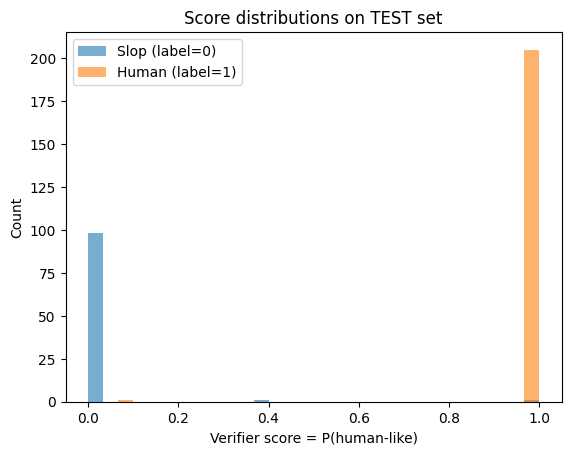

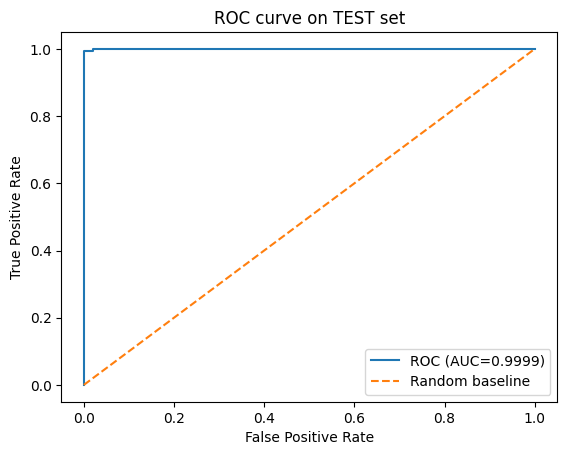


Most 'human-like' slop (label=0 with highest P(human)):


,p_human,pred,text
126,0.995063,1,I’ve written some of this because I’m not a fa...
103,0.399538,0,The Mind in the Body\nIf you’re reading this o...
203,0.006891,0,A Practical Practical Practical Practical Prac...
154,0.006399,0,Islam. Be careful if you will miss it. If you ...
186,0.004116,0,The Brain Is Made of Nature – The Mind is Made...



Most 'slop-like' human (label=1 with lowest P(human)):


,p_human,pred,text
7,0.093251,0,"In 1989, Cambridge University Press announced ..."
58,0.998281,1,"Parwati Soepangat (1932-2016), fondly known as..."
220,0.998422,1,In the past few years I have spent a lot of ti...
87,0.998474,1,The anonymous author of the pamphlet Onania (1...
130,0.998494,1,If the sultan of Mysore had had a bit more luc...



Closest-to-threshold samples overall (hardest cases):


,y_true,p_human,pred,text
103,0,0.399538,0,The Mind in the Body\nIf you’re reading this o...
7,1,0.093251,0,"In 1989, Cambridge University Press announced ..."
203,0,0.006891,0,A Practical Practical Practical Practical Prac...
154,0,0.006399,0,Islam. Be careful if you will miss it. If you ...
126,0,0.995063,1,I’ve written some of this because I’m not a fa...
186,0,0.004116,0,The Brain Is Made of Nature – The Mind is Made...
77,0,0.003498,0,- The United States is at war. Our economy is ...
291,0,0.003481,0,Warranty:\nWarranty:\nWarranty:\nWarranty:\nWa...
29,0,0.003294,0,Rituals and celebrations. Use a generic high-s...
253,0,0.003191,0,A Tale of the New American Novels\nYou might l...


In [ ]:
# === CELL SUMMARY ===
# Visualization cell.
# Plots:
# - Histogram of P(human) for human vs slop
# - ROC curve
# Also prints ranked examples for debugging (most human-like slop / most slop-like human).
# ====================

# === Plots + ranked examples (drop-in cell) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Safety checks
assert "probs" in globals() and "y" in globals() and "test_df" in globals(), \
    "Expected variables: probs (P(human)), y (labels), test_df (with 'text' column)."

probs = np.asarray(probs)
y = np.asarray(y).astype(int)

# Split by class
probs_human = probs[y == 1]
probs_slop  = probs[y == 0]

print(f"Test set sizes | human: {len(probs_human)} | slop: {len(probs_slop)}")
print(f"Mean P(human)  | human: {probs_human.mean():.4f} | slop: {probs_slop.mean():.4f}")
print(f"Median P(human)| human: {np.median(probs_human):.4f} | slop: {np.median(probs_slop):.4f}")

# 1) Histogram plot
plt.figure()
bins = np.linspace(0, 1, 31)
plt.hist(probs_slop, bins=bins, alpha=0.6, label="Slop (label=0)")
plt.hist(probs_human, bins=bins, alpha=0.6, label="Human (label=1)")
plt.xlabel("Verifier score = P(human-like)")
plt.ylabel("Count")
plt.title("Score distributions on TEST set")
plt.legend()
plt.show()

# 2) ROC curve
auc = roc_auc_score(y, probs) if len(np.unique(y)) > 1 else float("nan")
fpr, tpr, _ = roc_curve(y, probs)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random baseline")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve on TEST set")
plt.legend()
plt.show()

# 3) Ranked examples: most confusing samples
# Attach probs + labels to test_df in the same order used for evaluation.
# NOTE: In your notebook, test_texts = test_df['text'].tolist() corresponds to the same ordering.
df_dbg = test_df.copy().reset_index(drop=True)
df_dbg["y_true"] = y
df_dbg["p_human"] = probs
df_dbg["pred"] = (df_dbg["p_human"] >= 0.5).astype(int)
df_dbg["abs_margin"] = np.abs(df_dbg["p_human"] - 0.5)

print("\nMost 'human-like' slop (label=0 with highest P(human)):")
top_slop = df_dbg[df_dbg["y_true"] == 0].sort_values("p_human", ascending=False).head(5)
display(top_slop[["p_human", "pred", "text"]].assign(text=top_slop["text"].str.slice(0, 350) + "..."))

print("\nMost 'slop-like' human (label=1 with lowest P(human)):")
top_human = df_dbg[df_dbg["y_true"] == 1].sort_values("p_human", ascending=True).head(5)
display(top_human[["p_human", "pred", "text"]].assign(text=top_human["text"].str.slice(0, 350) + "..."))

print("\nClosest-to-threshold samples overall (hardest cases):")
hardest = df_dbg.sort_values("abs_margin", ascending=True).head(10)
display(hardest[["y_true", "p_human", "pred", "text"]].assign(text=hardest["text"].str.slice(0, 250) + "..."))
